In [3]:
# coding=u8
import vectorbt as vbt
import pandas_ta as ta
import pandas as pd
import warnings
import numpy as np
import datetime


warnings.simplefilter(action='ignore')

pd.set_option("display.max_rows", 1000)

In [4]:
df = pd.read_csv('AAPL.csv')
df = df.rename(columns={'Date':'d','Open':'o','High':'h','Low':'l','Close':'c','Volume':'v'})
df = df[['d','o','h','l','c','v']]

df = df.set_index('d')

In [34]:
df = pd.read_csv('BTCUSDT_2021-01-01.csv')
#df = pd.read_csv('BTC_USDT-2020-01-01.csv')
df['dt'] = df['t'].apply(lambda x: datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

df = df.set_index('dt')

In [35]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 13874 entries, 2021-01-01 00:00:00 to 2022-08-02 01:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       13874 non-null  int64  
 1   o       13874 non-null  float64
 2   h       13874 non-null  float64
 3   l       13874 non-null  float64
 4   c       13874 non-null  float64
 5   v       13874 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 758.7+ KB
None


,t,o,h,l,c,v
dt,,,,,,
2021-01-01 00:00:00,1609459200000,28921.5,29026.0,28703.5,28990.0,917.494
2021-01-01 01:00:00,1609462800000,28990.0,29505.5,28956.5,29411.0,1927.830
2021-01-01 02:00:00,1609466400000,29411.0,29462.0,29150.0,29218.0,931.537
2021-01-01 03:00:00,1609470000000,29218.0,29358.5,29171.5,29303.0,440.535
2021-01-01 04:00:00,1609473600000,29303.0,29397.5,29078.0,29229.5,711.549


In [7]:
df.loc[df.index[1], 'o']

28990.0

In [36]:
df['price'] = np.inf


def build_df(bb_len, rsi_len, rsi_v, buy_signal_cnt_limit):
    entry_list = {}
    exit_list = {}
    
    last_buy_signal_cnt = 0
    in_position = False

    df_copy = df.copy()
    df_copy[['lower','mid','upper','bandwidth','percent']] = ta.bbands(df_copy['c'], length=bb_len, std=2.5)
    df_copy = df_copy.dropna(subset=['lower'])
    df_copy['rsi'] = ta.rsi(df_copy['c'], length=rsi_len)
    df_copy['cross_rsi'] = ta.above_value(df_copy['rsi'], rsi_v)
    df_copy['ma'] = ta.sma(df_copy['c'], length=200)

    for i, (index, row) in enumerate(df_copy.iterrows()):
        entry_list[index] = False
        exit_list[index] = False
        if (row['c'] < row['lower']) and (row['c'] > row['ma']):
            # 入场条件1
            limit_price = df_copy.loc[df_copy.index[i-1], 'c'] * 0.97
            if row['l'] < limit_price:
                # 入场条件2
                entry_list[index] = True
                in_position = True
                df_copy.at[index, 'price'] = limit_price
                last_buy_signal_cnt = 0
            
        if in_position:
            last_buy_signal_cnt += 0

        if row['cross_rsi'] == 1:
            exit_list[index] = True
            df_copy.at[index,'price'] = row['c']
            last_buy_signal_cnt = 0

        if last_buy_signal_cnt > buy_signal_cnt_limit:
            last_buy_signal_cnt = 0
    
    
    df_copy['entry'] = entry_list.values()
    df_copy['exit'] = exit_list.values()
    
    return df_copy

In [ ]:
{'2021-01-01: 01:00:00': True, '2021-01-01 02:00:00': False, ......}

In [17]:
# df[['o','h','l','c','v','cross_rsi','rsi','entry','exit']].head(200)

In [47]:
# df_ = build_df(20, 2, 50, 10)
param_list = []

for x in range(15, 30):
    for y in range(2,5):
        df_ = build_df(x, y, 50, 10)
        pf = vbt.Portfolio.from_signals(df_['c'], entries=df_['entry'], exits=df_['exit'], price=df_['price'],
                                    init_cash=30000, accumulate=True)
        
        winrate = pf.stats()[r'Win Rate [%]']
        total_return = pf.stats()[r'Total Return [%]']
        total_profit = pf.total_profit()
        max_drawdown = pf.max_drawdown()
        total_trades = len(pf.trades)
        # print('total profit', total_profit)
        print('total_return', total_return)
        # print('total trades', total_trades)

        param_list.append((x,y,total_return,total_trades,winrate))



total_return 4.350801418046054
total_return 2.35466468568559
total_return 2.849908234491583
total_return 4.350801418046054
total_return 2.35466468568559
total_return 2.849908234491583
total_return 4.350801418046054
total_return 2.35466468568559
total_return 2.849908234491583
total_return 5.81394032301346
total_return 3.917195984847482
total_return 5.018930402010701
total_return 5.81394032301346
total_return 3.917195984847482
total_return 5.018930402010701
total_return 5.81394032301346
total_return 3.917195984847482
total_return 5.018930402010701
total_return 5.7711297624680205
total_return 3.8941539648686496
total_return 4.995644089581414
total_return 5.81394032301346
total_return 3.917195984847482
total_return 5.018930402010701
total_return 5.189087486303833
total_return 3.587918088962809
total_return 4.8263796194730455
total_return 5.645839917906669
total_return 3.8941539648686496
total_return 4.995644089581414
total_return 8.240491165088994
total_return 6.445783980488437
total_retur

In [39]:
param_list

[(15, 2, 4.350801418046054, 6, 100.0),
 (15, 3, 2.35466468568559, 6, 83.33333333333334),
 (15, 4, 2.849908234491583, 6, 83.33333333333334),
 (16, 2, 4.350801418046054, 6, 100.0),
 (16, 3, 2.35466468568559, 6, 83.33333333333334),
 (16, 4, 2.849908234491583, 6, 83.33333333333334),
 (17, 2, 4.350801418046054, 6, 100.0),
 (17, 3, 2.35466468568559, 6, 83.33333333333334),
 (17, 4, 2.849908234491583, 6, 83.33333333333334),
 (18, 2, 5.81394032301346, 7, 100.0),
 (18, 3, 3.917195984847482, 7, 85.71428571428571),
 (18, 4, 5.018930402010701, 7, 85.71428571428571),
 (19, 2, 5.81394032301346, 7, 100.0),
 (19, 3, 3.917195984847482, 7, 85.71428571428571),
 (19, 4, 5.018930402010701, 7, 85.71428571428571),
 (20, 2, 5.81394032301346, 7, 100.0),
 (20, 3, 3.917195984847482, 7, 85.71428571428571),
 (20, 4, 5.018930402010701, 7, 85.71428571428571),
 (21, 2, 5.7711297624680205, 6, 100.0),
 (21, 3, 3.8941539648686496, 6, 83.33333333333334),
 (21, 4, 4.995644089581414, 6, 83.33333333333334),
 (22, 2, 5.813940

In [48]:
df_ = build_df(26, 2, 50, 10)
pf = vbt.Portfolio.from_signals(df_['c'], entries=df_['entry'], exits=df_['exit'], price=df_['price'],
                                    init_cash=30000, accumulate=True)

In [49]:
orders = pf.orders
print(orders.records_readable)

    Order Id  Column            Timestamp      Size      Price  Fees  Side
0          0       0  2021-01-10 11:00:00  0.764188  39257.355   0.0   Buy
1          1       0  2021-01-10 13:00:00  0.764188  39767.000   0.0  Sell
2          2       0  2021-01-10 17:00:00  0.797286  38116.150   0.0   Buy
3          3       0  2021-01-10 21:00:00  0.797286  38071.000   0.0  Sell
4          4       0  2021-02-12 14:00:00  0.653003  46482.885   0.0   Buy
5          5       0  2021-02-12 16:00:00  0.653003  47624.500   0.0  Sell
6          6       0  2021-02-15 02:00:00  0.665741  46713.260   0.0   Buy
7          7       0  2021-02-15 07:00:00  0.665741  47260.000   0.0  Sell
8          8       0  2021-03-15 09:00:00  0.559816  56202.285   0.0   Buy
9          9       0  2021-03-15 12:00:00  0.559816  56442.000   0.0  Sell
10        10       0  2021-05-04 00:00:00  0.569487  55483.515   0.0   Buy
11        11       0  2021-05-04 04:00:00  0.569487  55836.000   0.0  Sell
12        12       0  202

In [50]:
pf.stats()

Start                         2021-01-02 01:00:00
End                           2022-08-02 01:00:00
Period                                      13849
Start Value                               30000.0
End Value                            32485.290358
Total Return [%]                         8.284301
Benchmark Return [%]                   -21.164579
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         2.860511
Max Drawdown Duration                      6339.0
Total Trades                                    9
Total Closed Trades                             9
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            88.888889
Best Trade [%]                            2.45599
Worst Trade [%]                         -0.118454
Avg Winning Trade [%]                    1.017189
Avg Losing Trade [%]                    -0.118454


In [51]:
pf.plot_orders()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showl…

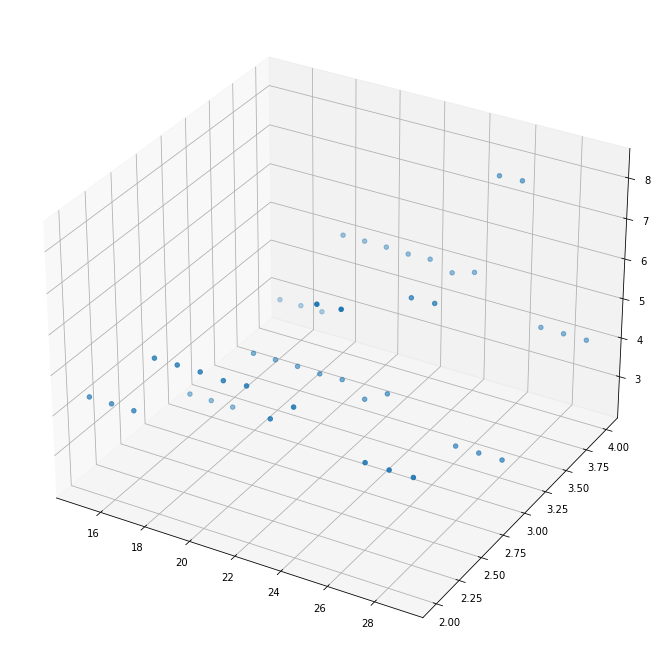

In [30]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')



ax.scatter([i[0] for i in param_list], [i[1] for i in param_list], [i[2] for i in param_list])
plt.show()